In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import torch

from glob import glob

In [2]:
# def Onehot(num):
#     output=[0,0,0,0,0,0,0,0,0,0,0]
#     output[num]=1
#     return output

In [3]:
train_x=[]
train_y=[]
for jpg in glob( "/home/raychiu/small_train/*.jpg" ):
    im = np.array(PIL.Image.open(jpg))
    #print(jpg)
    im.resize(3,200,200)
    train_x.append(im)
    png=os.path.splitext(os.path.basename(jpg))[0]
    loc=png.find('_')
    cl=int(png[0:loc])
    tmp_cl=cl #Onehot(cl)
    train_y.append(tmp_cl)
    #print(cl)

train_x=np.array(train_x)/255 #.reshape(-1,3,200,200)/255
train_y=torch.LongTensor(np.array(train_y, ).reshape(9866,-1))

tensor([ 9])


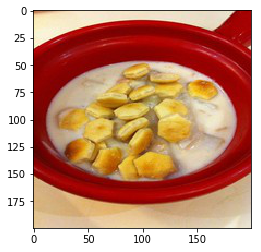

In [4]:
plt.imshow(train_x[5].reshape(200,200,3))
print(train_y[5])

In [5]:
test_x=[]
test_y=[]
for jpg in glob( "/home/raychiu/small_evaluation/*.jpg" ):
    im = np.array(PIL.Image.open(jpg))
    #print(jpg)
    im.resize(3,200,200)
    test_x.append(im)
    png=os.path.splitext(os.path.basename(jpg))[0]
    loc=png.find('_')
    cl=int(png[0:loc])
    tmp_cl=cl#Onehot(cl)
    test_y.append(tmp_cl)
    #print(cl)
    
test_x=np.array(test_x)/255#.reshape(-1,3,200,200)/255
test_y=torch.LongTensor(np.array(test_y, ).reshape(3347,-1))

In [6]:
train_x.shape

(9866, 3, 200, 200)

In [7]:
classes = ('Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food'
           , 'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup','Vegetable/Fruit')

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3,padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        #self.conv4 = nn.Conv2d(32, 64, 3)#, padding=1)
        self.fc1 = nn.Linear(32 * 25 * 25, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 11)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #x = self.pool(F.relu(self.conv4(x)))
        x = x.view( -1,32 * 25 * 25)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = (self.fc3(x))
        #return x
        return F.log_softmax(x, dim=1)

net = Net()
#net.cuda()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=20000, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=11, bias=True)
)


In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [10]:
import torch.utils.data as Data
trainset = Data.TensorDataset(
    torch.FloatTensor(train_x),
    train_y 
)
testset = Data.TensorDataset(
     torch.FloatTensor(test_x),
     test_y 
)

In [11]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, )#num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=50,
                                          shuffle=False,)# num_workers=2)

In [14]:
loss_ = []
train_acc = []
test_acc = []
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        labels = labels.view(-1)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        
        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss/30))
            loss_.append(running_loss/30)
            running_loss = 0.0
    correct = 0
    total = 0
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        labels = labels.reshape(-1,labels.size(0))[0]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_acc.append(correct/total)
    print('train_acc = ', correct/total)
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        labels = labels.reshape(-1,labels.size(0))[0]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('test_acc = ', correct/total)
    test_acc.append(correct/total)

print('Finished Training')

[1,    30] loss: 2.412


KeyboardInterrupt: 

In [ ]:
#training 
dataiter = iter(trainloader)
images, labels = dataiter.next()
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# print images
for i in range(4):
    plt.imshow(images[i].reshape(200,200,3))
    plt.show()
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[i]]))
    print('Predicted: ', ' '.join('%5s' % classes[predicted[i]] ))

In [ ]:
#testing
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# print images
for i in range(4):
    plt.imshow(images[i+5].reshape(200,200,3))
    plt.show()
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[i+5]]))
    print('Predicted: ', ' '.join('%5s' % classes[predicted[i+5]] ))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        labels = labels.reshape(-1,labels.size(0))[0]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d train images: %f %%' % ((train_y).size(0) , (100*correct / total)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        labels = labels.reshape(-1,labels.size(0))[0]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %f %%' % ((test_y).size(0) , (100*correct / total)))

In [ ]:
loss_ep = []
for i in range(100):
    loss_ep.append((loss_[i]+loss_[i+1]+loss_[i+2]+loss_[i+3]+
              loss_[i+4]+loss_[i+5])/6)
t = np.arange(100)
plt.plot(t,loss_ep)
plt.title('Learing Curve without L2 norm')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.show()

In [ ]:
p1 =plt.plot(t,train_acc,'r', label='training_accuracy')
p2 = plt.plot(t,test_acc,'b', label='test_accuracy')
plt.title('training and test accuray without L2 norm')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc='lower right') 
plt.show()

In [ ]:
a = net.conv1.weight
plt.hist(a.detach().numpy().reshape(-1),bins = 80)  
plt.title("Histogram of conv1")
plt.show()

a = net.conv2.weight
plt.hist(a.detach().numpy().reshape(-1),bins = 80) 
plt.title("Histogram of conv2")
plt.show()

a = net.conv3.weight
plt.hist(a.detach().numpy().reshape(-1),bins = 80)  
plt.title("Histogram of conv3")
plt.show()

a = net.fc1.weight
plt.hist(a.detach().numpy().reshape(-1),bins = 80) 
plt.title("Histogram of fc1")
plt.show()

a = net.fc2.weight
plt.hist(a.detach().numpy().reshape(-1),bins = 80)  
plt.title("Histogram of fc2")
plt.show()

a = net.fc3.weight
plt.hist(a.detach().numpy().reshape(-1),bins = 80) 
plt.title("Histogram of fc3")
plt.show()

In [ ]:
(images[0].reshape(-1) * net.conv1.weight.reshape(-1))

In [ ]:
net.conv1.weight.size()

In [ ]:
images[0].size()

In [ ]:
nn.Conv2d